# Hybrid Monte Carlo Methods

In [52]:
import numpy as np 
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from collections import deque
%matplotlib notebook

## Solve regular harmonic oscillator using leapfrog method
First just want to get the solution to the differential equations and should find oscillatory motion

Update x first in time step and then use this update in x to update p and vice versa. 

In [2]:
#Write general functions for the leapfrog integration

#New space coordinate function
def space_integrator(space, momentum, time_step, potential_derivative):
    return (space + momentum*time_step + 0.5*potential_derivative*(time_step**2))

#New momentum coordinate function
def momentum_integrator(momentum, time_step, previous_potential_derivative, new_potential_derivative):
    return momentum + 0.5*(previous_potential_derivative+new_potential_derivative)*time_step

In [3]:
#Initialise boundary conditions first 
p0=0
x0=1

#Timestep
dt=0.01

xs=np.array([x0])
ps=np.array([p0])
#Derivative of regular SHO potential 
d_pot=-xs
times=np.arange(0,10+dt,dt)
 
#Loop to populate the x and p arrays 
for ii in range(len(times)-1):
    x_placeholder=space_integrator(xs[-1],ps[-1],dt,d_pot[-1])
    #Update x array
    xs=np.append(xs, np.array([x_placeholder]))
    #Update potential 
    d_pot=-xs
    
    #Generate momenta
    #Careful that the potential array has now been updated 
    p_placeholder=momentum_integrator(ps[-1], dt, d_pot[-2], d_pot[-1])
    #Update the p array
    ps=np.append(ps, np.array([p_placeholder]))

<IPython.core.display.Javascript object>


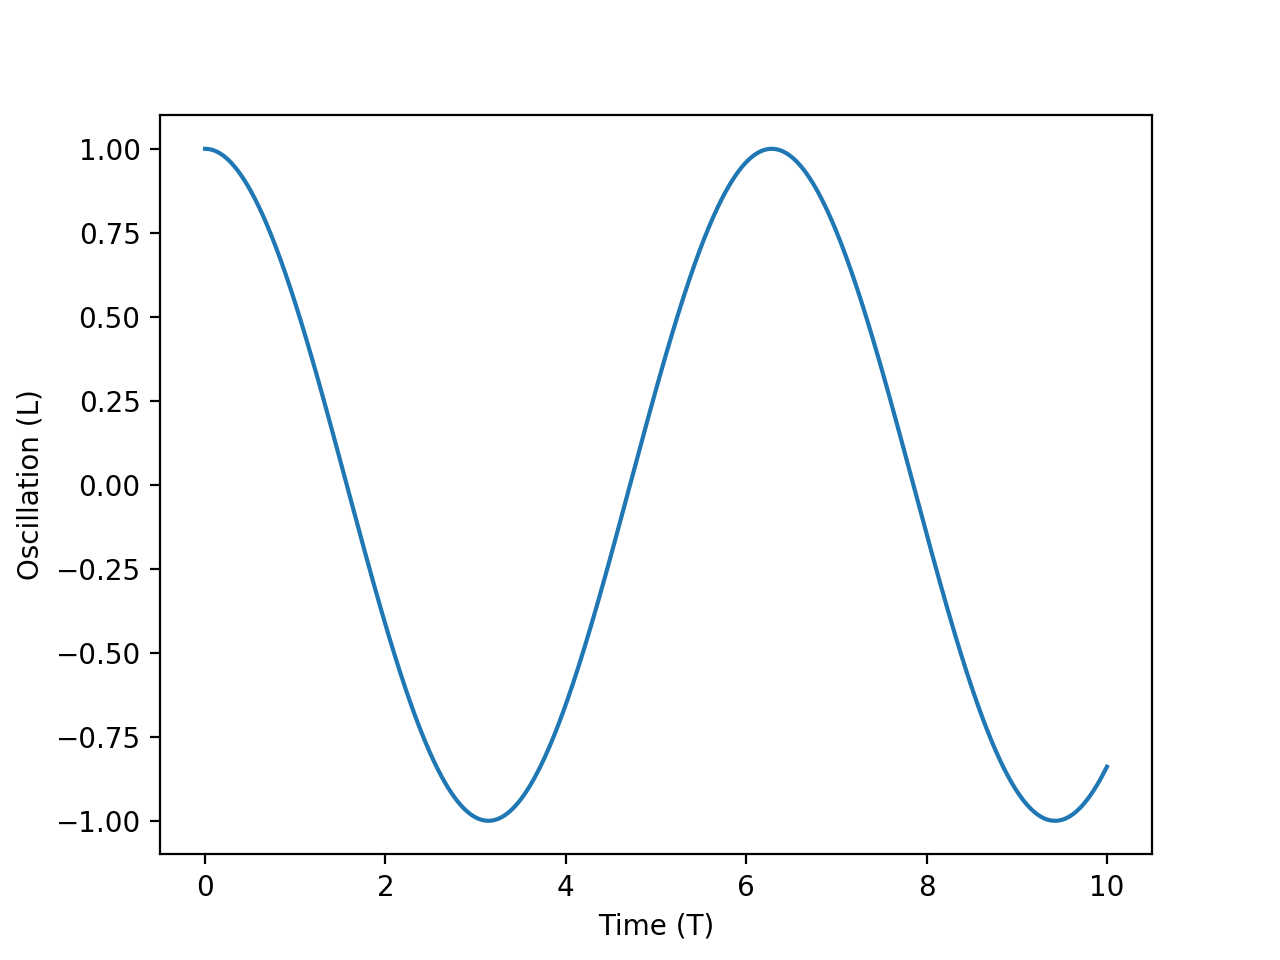

Text(0, 0.5, 'Oscillation (L)')

In [4]:
#Plot the motion against time 
%matplotlib notebook
plt.plot(times, xs)
plt.xlabel('Time (T)')
plt.ylabel('Oscillation (L)')

## Calculating distributions using HMC 

In [58]:
#Start with the Metropolis Algorithm
#Randomly generate the first configuration
L=10
x0=L*np.random.uniform(-1,1)
suc=0
n_it=0
terms_wanted=1e3

#Store the successes
x_suc=np.array([x0])

#Timestep for evolution
dt=0.1
times=np.arange(0,3+dt,dt)

#Timing 
tick=time.time()

#Start testing
while len(x_suc)<terms_wanted:
    n_it+=1
    x_test=np.array([x_suc[-1] + 1.3*np.random.uniform(-1,1)])
    
    #Now let it evolve through Hamiltonian mechanics 
    #Loop to populate the x and p arrays 
    #Start with random momentum 
    ps=np.array([np.random.uniform(0,1)])
    d_pot=-x_test
    
    for ii in range(len(times)-1):
        x_evolution=space_integrator(x_test[-1],ps[-1],dt,d_pot[-1])
        #Update x array
        x_test=np.append(x_test, np.array([x_evolution]))
        #Update potential 
        d_pot=-x_test

        #Generate momenta
        #Careful that the potential array has now been updated 
        p_placeholder=momentum_integrator(ps[-1], dt, d_pot[-2], d_pot[-1])
        #Update the p array
        ps=np.append(ps, np.array([p_placeholder]))
        
    #Test
    ds=(x_test[-1]**2+0.5*(ps[-1])**2)-((x_suc[-1]**2)+0.5*(ps[0]**2))
    if np.exp(-ds)>np.random.uniform(0,1):
        suc+=1
        x_suc=np.append(x_suc, x_test[-1])
        
tock=time.time()
        
ratio=suc/n_it
print(ratio)
print('Time taken is',tock-tick)

0.6655562958027982
Time taken is 0.7847967147827148


<IPython.core.display.Javascript object>


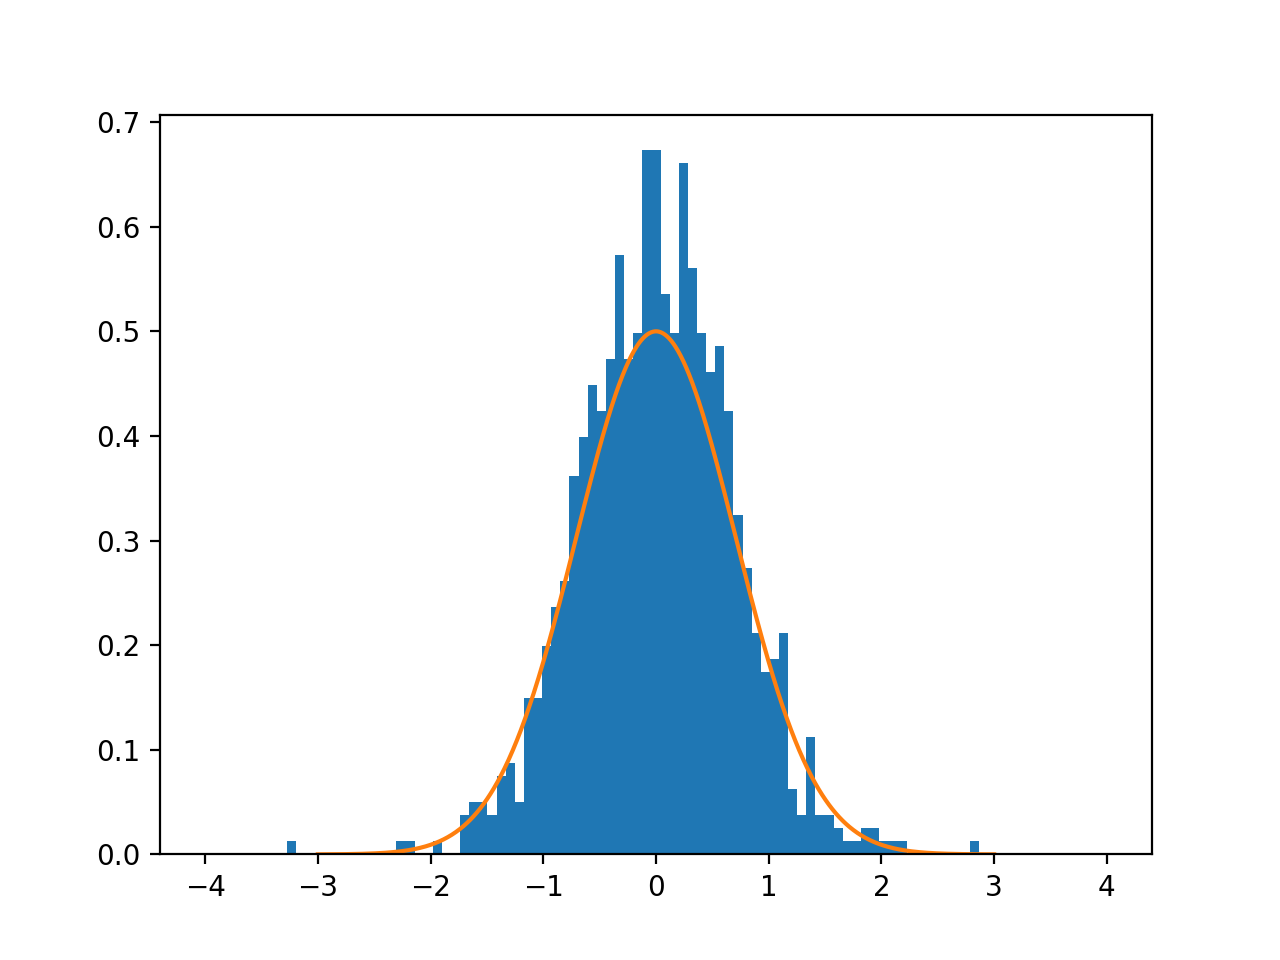

The mean of x is 0.017590
The mean of x^2 is 0.684864


In [48]:
#Results and plotting §
%matplotlib notebook
plt.hist(x_suc, density=1, bins=np.linspace(-4,4,100))
plt.plot(np.linspace(-3,3,1000), 0.5*np.exp(-(np.linspace(-3,3,1000)**2)))

print('The mean of x is %f' % np.mean(x_suc))
print('The mean of x^2 is %f' % np.mean(x_suc**2))

## HMC for more complex potential varying with a 

In [14]:
#Generate array of a values
a=np.arange(-5,5.25,0.25)

#Function to return potential given a and x
def potential(a,x):
    return a*x**2 + x**4

#Create a function to find the gradient of potential for a given a 
def grad_pot(a,x):
    return 2*a*x + 4*x**3

#Function to return the instantaneous Hamiltonian of a system
def hamiltonian(potential, momentum):
    return potential + 0.5*momentum**2

#Length of interval considered 
L=10

#Sensitivity of guesses
e=1.0

#Time ranges 
times=np.linspace(0,5,100)
dt=times[1]-times[0]

#Keep track of iterations and successes 
iterations=0
successes=0

#Initialise array to hold each <x> value
mean_x=np.zeros(len(a))

#Initialise array to hold each <x2> value
mean_xsqr=np.zeros(len(a))

for ii in range(len(a)):
    #Keep track of iterations and successes 
    iterations=0
    successes=0

    #Initialise array to hold each x value 
    x=np.zeros(1000)
    x[0]=np.random.uniform(-1,1)*L
    
    #Array for tracking the evolution of each given x value
    x_evolution=np.zeros(len(times))
    
    #Array for tracking momentum of each time value 
    p_evolution=np.zeros(len(times))
    
    for jj in range(1,len(x)):
        iterations+=1
        x_evolution[0]=x[jj-1]+e*np.random.uniform(-1,1)
        #Start with a random momentum impulse between 0 and 1
        p_evolution[0]=np.random.uniform(0,1)
         
        #Calculate array of derivative of potential for given x 
        d_potential=grad_pot(a[ii], x_evolution)
        
        for kk in range(1, len(times)):
            x_evolution[kk]=space_integrator(x_evolution[kk-1], p_evolution[kk-1], dt, d_potential[kk-1])
            #Update potential for new x
            d_potential=x_evolution
            #Update momentum
            p_evolution[kk]=momentum_integrator(p_evolution[kk-1], dt, d_potential[kk-1], d_potential[kk])
            
        #Testing now that evolution has been allowed
        ds=hamiltonian(potential(a[ii], x_evolution[-1]), p_evolution[-1])-hamiltonian(potential(a[ii], x[jj-1]), p_evolution[0])
        if np.exp(-ds)>np.random.uniform(0,1):
            successes+=1
            x[jj]=x_evolution[0]
            
    print(successes/iterations)
    #Calculating <x> and <x2> for given x profile 
    mean_x[ii]=np.mean(x)
    mean_xsqr[ii]=np.mean((x**2))

0.018018018018018018
0.026026026026026026
0.024024024024024024
0.025025025025025027
0.014014014014014014
0.025025025025025027
0.01701701701701702
0.018018018018018018
0.02002002002002002
0.01901901901901902
0.022022022022022022
0.015015015015015015
0.015015015015015015
0.009009009009009009
0.021021021021021023
0.009009009009009009
0.014014014014014014
0.011011011011011011
0.012012012012012012
0.005005005005005005
0.009009009009009009
0.012012012012012012
0.005005005005005005
0.006006006006006006
0.008008008008008008
0.004004004004004004
0.008008008008008008
0.004004004004004004
0.006006006006006006
0.008008008008008008
0.003003003003003003
0.006006006006006006
0.007007007007007007
0.005005005005005005
0.005005005005005005
0.008008008008008008
0.003003003003003003
0.006006006006006006
0.004004004004004004
0.005005005005005005


KeyboardInterrupt: 